## On the top right of VS Code, make sure to changethe kernel/environment to: 'airline-delay-prediction

### Make sure to have also ran 00 and 01 and 02.ipynb notebooks

In [1]:
from pathlib import Path
import os

def to_repo_root(start=Path.cwd()):
    for p in [start, *start.parents]:
        if (p/"src").exists() and (p/"requirements.txt").exists():
            os.chdir(p); print("Project root:", p); return
    raise SystemExit("Could not locate project root (needs ./src and ./requirements.txt)")

to_repo_root()


Project root: /Users/nikhilroy/Documents/MSML610/repo


In [ ]:
from src.utils_model import (
    SCHEMA, BASE_CATEGORICAL, BASE_NUMERIC,
    load_model, load_metrics, predict_proba, coerce_schema,
    pick_threshold, load_all_metrics_table, score_row, score_dataframe
)


Quick Data Insight (really to make sure my parquet file is actually stored and able to retrived hahaha):

In [2]:
from pyarrow import dataset as ds
import pandas as pd

tbl = ds.dataset("data/processed/flights_with_weather.parquet", format="parquet").to_table()
df = tbl.select(["is_delayed","FL_DATE"]).to_pandas()
print("rows:", len(df), " delay rate:", df["is_delayed"].mean())
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])
print("date range:", df["FL_DATE"].min(), "→", df["FL_DATE"].max())


rows: 5819079  delay rate: 0.19300541645905558
date range: 2015-01-01 00:00:00 → 2015-12-31 00:00:00


### Make sure dependecies are installed for the models:

In [3]:
# Run in the airline-delay-prediction kernel
import sys, subprocess, os
subprocess.run(
    ["conda","install","-n","airline-delay-prediction","-c","conda-forge","llvm-openmp","-y"],
    check=False
)
print("CONDA_PREFIX:", os.environ.get("CONDA_PREFIX", sys.prefix))


Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda





## Package Plan ##

  environment location: /Users/nikhilroy/opt/anaconda3/envs/airline-delay-prediction

  added / updated specs:
    - llvm-openmp


The following NEW packages will be INSTALLED:

  llvm-openmp        conda-forge/osx-64::llvm-openmp-21.1.5-h472b3d1_2


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
CONDA_PREFIX: /Users/nikhilroy/opt/anaconda3/envs/airline-delay-prediction


Have to run below before modeling in order to establish our modeling and depencies (doesn't work in requirements.txt, i tried)

In [4]:
import os, sys, glob, ctypes, importlib

env_prefix = os.environ.get("CONDA_PREFIX", sys.prefix)
candidates = glob.glob(os.path.join(env_prefix, "lib", "libomp*.dylib"))
print("Found libomp candidates:", candidates)

if not candidates:
    raise RuntimeError("libomp.dylib not found in the conda env. Make sure llvm-openmp installed in THIS env.")

libomp_path = candidates[0]
# Preload OpenMP before importing xgboost
ctypes.CDLL(libomp_path)

# (Optional) nudge the loader to see the env's lib directory first
os.environ["DYLD_LIBRARY_PATH"] = env_prefix + "/lib:" + os.environ.get("DYLD_LIBRARY_PATH","")

# Now import/test xgboost
import xgboost as xgb, numpy as np
print("XGBoost version:", xgb.__version__)
X = np.random.randn(200, 10); y = (np.random.rand(200) > 0.8).astype(int)
d = xgb.DMatrix(X, label=y)
xgb.train({'objective':'binary:logistic','tree_method':'hist','verbosity':0}, d, num_boost_round=1)
print("XGBoost OK")


Found libomp candidates: ['/Users/nikhilroy/opt/anaconda3/envs/airline-delay-prediction/lib/libomp.dylib']
XGBoost version: 2.1.1
XGBoost OK


## Training XGBoost on Entire Data (beaware this takes forever):

provides: built-in logloss/AUC/AUCPR printed by XGBoost every N rounds (this case/default, every 25 trees) plus our callback’s Precision / Recall / F1 (at best-F1 threshold) and ROC-AUC, on validation—and optionally training—for clear, imbalance-aware monitoring during the run (as you can see in my already ran cell how the output is styled )

### Initially, you can see a super high correlation with some variables, specially the "departure_delay", where it provides the amount of minutes the flight got delayed. Now, this is way too overpowerful of a feature because once we know the time > a threshold, then it's so obvious that flight is delayed. However, more importantly, if I actually want to use this in production and real time, we won't know the actual departure time delay until after the relavency is over. In other words, we need features that are set in stone and only affect our current or past time and nothing that is past T of theta.

1. This naive runs all the features (including the dominant departure_delay) and updates the model's performance every N times (25 here/default) and creates plots of the importance, etc. 

The next block below will get rid of those leakage where we would require some data in the future or too powerful, providing more realistic and user insights.

In [6]:
%run src/train_xgb.py \
  --in_path data/processed/flights_with_weather.parquet \
  --out_dir models \
  --split time --eval_size 0.20 \
  --early_stopping 50 \
  --n_estimators 1001 \
  --log_period 25 \
  --use_departure_delay true \
  --tag all_features \
  --native true \
  --learning_rate 0.1






[0]  valid_logloss=0.63557  valid_F1=0.800  valid_auc=0.934  valid_aucpr=0.876  train_logloss=0.63289  train_F1=0.803  train_auc=0.936  train_aucpr=0.877
[25]  valid_logloss=0.32208  valid_F1=0.805  valid_auc=0.945  valid_aucpr=0.885  train_logloss=0.29728  train_F1=0.809  train_auc=0.950  train_aucpr=0.890
[50]  valid_logloss=0.27819  valid_F1=0.810  valid_auc=0.950  valid_aucpr=0.894  train_logloss=0.24920  train_F1=0.815  train_auc=0.955  train_aucpr=0.899
[75]  valid_logloss=0.26649  valid_F1=0.816  valid_auc=0.953  valid_aucpr=0.900  train_logloss=0.23587  train_F1=0.822  train_auc=0.959  train_aucpr=0.906
[100]  valid_logloss=0.25774  valid_F1=0.824  valid_auc=0.956  valid_aucpr=0.906  train_logloss=0.22559  train_F1=0.831  train_auc=0.962  train_aucpr=0.913
[125]  valid_logloss=0.25155  valid_F1=0.829  valid_auc=0.958  valid_aucpr=0.909  train_logloss=0.21850  train_F1=0.837  train_auc=0.965  train_aucpr=0.918
[150]  valid_logloss=0.24747  valid_F1=0.832  valid_auc=0.959  valid_

### What each of those output columns represent:

- [N]: The boosting round (iteration) number just completed (e.g., [25] means after 25 trees).

- valid_logloss: Log loss on the validation split using the model’s current raw probabilities. Lower is better; penalizes confident wrong predictions.

- valid_auc: ROC-AUC on the validation split. Threshold-free discrimination metric (probability ranking quality). Higher is better.

- valid_aucpr: PR-AUC on the validation split. Better reflects performance on imbalanced data (focuses on the positive class). Higher is better.

- valid_P: Precision on the validation split at the threshold that maximizes F1 on the validation split. Of the flights predicted “delayed,” what fraction actually are delayed?

- valid_R: Recall on the validation split at the F1-optimal threshold. Of all delayed flights, what fraction did we catch?

- valid_F1: F1 score on the validation split at that same threshold (harmonic mean of precision and recall). Peak F1 is what the code optimizes when choosing the threshold for display.

- train_P / train_R / train_F1: The same precision/recall/F1 metrics but computed on the training split, at the validation’s F1-optimal threshold evaluated on train (so you can spot over/underfitting by comparing to valid_*).

- train_auc: ROC-AUC on the training split (threshold-free), useful to compare against valid_auc for overfitting checks.

- final line at the end ([best_iter=…] final_valid_auc=… final_valid_aucpr=… best_F1=… th=… P=… R=…): A summary using the best iteration chosen by early stopping:

- best_iter: The iteration with lowest validation logloss (early stopping’s pick).

- final_valid_auc / final_valid_aucpr: ROC-AUC and PR-AUC at best_iter.

- best_F1: Best validation F1 at its corresponding decision threshold.

- th: That probability threshold used to binarize predictions (≥ th → delayed).

- P / R: Precision and Recall on validation at that threshold.

### 2. Now, let's run WITHOUT departure_delay feature or any futuristic features with insaley high correlations:

In [6]:
%run src/train_xgb.py \
  --in_path data/processed/flights_with_weather.parquet \
  --out_dir models \
  --split time --eval_size 0.20 \
  --early_stopping 50 \
  --n_estimators 1001 \
  --log_period 25 \
  --use_departure_delay false \
  --tag removed_departure_delay_feature \
  --native true \
  --learning_rate 0.2









[0]  valid_logloss=0.70150  valid_F1=0.341  valid_auc=0.573  valid_aucpr=0.230  train_logloss=0.68346  train_F1=0.346  train_auc=0.620  train_aucpr=0.283
[25]  valid_logloss=0.69944  valid_F1=0.356  valid_auc=0.618  valid_aucpr=0.284  train_logloss=0.63711  train_F1=0.388  train_auc=0.682  train_aucpr=0.360
[50]  valid_logloss=0.69378  valid_F1=0.366  valid_auc=0.640  valid_aucpr=0.319  train_logloss=0.62030  train_F1=0.410  train_auc=0.706  train_aucpr=0.401
[75]  valid_logloss=0.68786  valid_F1=0.370  valid_auc=0.647  valid_aucpr=0.334  train_logloss=0.61189  train_F1=0.419  train_auc=0.717  train_aucpr=0.419
[100]  valid_logloss=0.68540  valid_F1=0.372  valid_auc=0.650  valid_aucpr=0.339  train_logloss=0.60775  train_F1=0.423  train_auc=0.721  train_aucpr=0.427
[125]  valid_logloss=0.68523  valid_F1=0.372  valid_auc=0.651  valid_aucpr=0.341  train_logloss=0.60499  train_F1=0.426  train_auc=0.724  train_aucpr=0.432
[150]  valid_logloss=0.68678  valid_F1=0.372  valid_auc=0.651  valid_

Big difference in removing our most signifigant feature!!! Let's definetely keep it.

### 3. Let's plot some visualizations here on losses of our 2 versions of the XgBoost:


=== xgb_all_features | use_departure_delay=True | best/n_rounds=661 ===


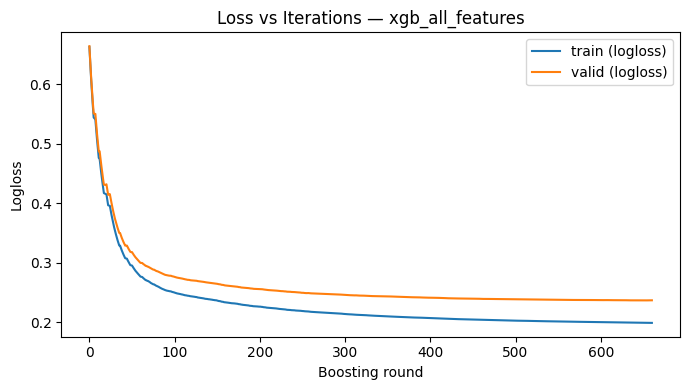

Saved: /Users/nikhilroy/Documents/MSML610/repo/models/xgb_all_features_loss_curve.png

=== xgb_no_departure_time_feature | use_departure_delay=False | best/n_rounds=1200 ===


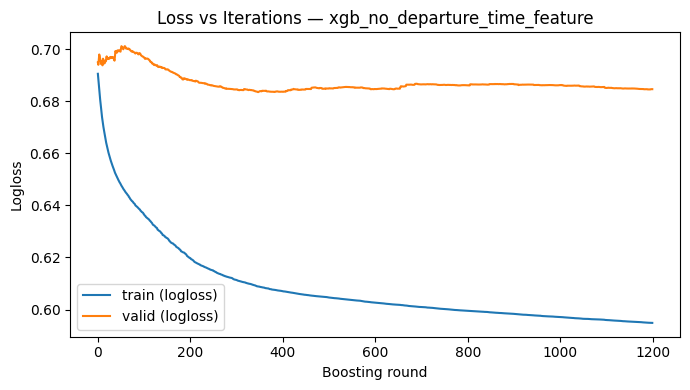

Saved: /Users/nikhilroy/Documents/MSML610/repo/models/xgb_no_departure_time_feature_loss_curve.png


In [10]:
# Plot train/valid logloss over iterations for two runs (all_features vs no_departure_time_feature)

import os, json, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import xgboost as xgb

warnings.filterwarnings("ignore")

# ---- Config matching your training script ----
DATA_PATH = "data/processed/flights_with_weather.parquet"
OUT_DIR   = Path("models")
EVAL_SIZE = 0.20
RANDOM_STATE = 610

BASE_CATEGORICAL = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","ORIGIN_STATE","DEST_STATE"]
BASE_NUMERIC = [
    "DEPARTURE_DELAY","AIR_TIME","DISTANCE",
    "ORIGIN_LAT","ORIGIN_LON","DEST_LAT","DEST_LON",
    "temp","rhum","prcp","snow","wspd","pres"
]

def read_parquet_df(path):
    return pq.read_table(path).to_pandas()

def coerce(df, numeric_cols):
    for c in numeric_cols + ["is_delayed"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "is_delayed" in df.columns:
        df["is_delayed"] = df["is_delayed"].fillna(0).astype(int)
    for c in numeric_cols:
        if c in df.columns:
            df[c] = df[c].astype("float32")
    if "FL_DATE" in df.columns:
        df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], errors="coerce")
    for c in BASE_CATEGORICAL:
        if c in df.columns:
            df[c] = df[c].astype("category")
    return df

def time_split(df, eval_size):
    df = df.sort_values("FL_DATE")
    cut = int((1.0 - eval_size) * len(df))
    return df.iloc[:cut], df.iloc[cut:]

def make_split(use_departure_delay: bool):
    numeric = [c for c in BASE_NUMERIC if use_departure_delay or c != "DEPARTURE_DELAY"]
    df = read_parquet_df(DATA_PATH)
    df = coerce(df, numeric_cols=numeric)
    X_all = df[BASE_CATEGORICAL + numeric + (["FL_DATE"] if "FL_DATE" in df.columns else [])].copy()
    y_all = df["is_delayed"].values

    tmp = X_all.join(pd.Series(y_all, name="y"))
    train_df, valid_df = time_split(tmp, EVAL_SIZE)
    X_tr = train_df.drop(columns=["y","FL_DATE"], errors="ignore")
    y_tr = train_df["y"].values
    X_va = valid_df.drop(columns=["y","FL_DATE"], errors="ignore")
    y_va = valid_df["y"].values

    # imbalance weight like training script
    pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
    spw = max(1.0, neg / max(pos, 1))

    return X_tr, y_tr, X_va, y_va, spw

def params_for(spw):
    return dict(
        objective="binary:logistic",
        eval_metric=["logloss","auc","aucpr"],
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        tree_method="hist",
        random_state=RANDOM_STATE,
        nthread=-1,
        scale_pos_weight=spw,
    )

def best_iter_from_metrics(prefix: str, default_iters: int = 1200) -> int:
    mpath = OUT_DIR / f"{prefix}_metrics.json"
    if mpath.exists():
        try:
            with open(mpath, "r") as f:
                meta = json.load(f)
            return int(meta.get("best_iteration", default_iters))
        except Exception:
            return default_iters
    return default_iters

def train_collect_history(prefix: str, use_departure_delay: bool, n_rounds: int, early_stopping: int = 100):
    X_tr, y_tr, X_va, y_va, spw = make_split(use_departure_delay)
    dtr = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
    dva = xgb.DMatrix(X_va, label=y_va, enable_categorical=True)

    ev_hist = {}
    bst = xgb.train(
        params_for(spw),
        dtr,
        num_boost_round=n_rounds,
        evals=[(dtr, "train"), (dva, "validation_0")],  # order gives us both
        evals_result=ev_hist,                           # <-- capture history here (works across versions)
        callbacks=[xgb.callback.EarlyStopping(rounds=early_stopping, save_best=True)],
        verbose_eval=False
    )
    # Return arrays for plotting (truncate to actual trained length)
    T = len(ev_hist["validation_0"]["logloss"])
    train_ll = np.array(ev_hist["train"]["logloss"][:T], dtype=float)
    valid_ll = np.array(ev_hist["validation_0"]["logloss"][:T], dtype=float)
    # Save a PNG and also return arrays
    fig_path = OUT_DIR / f"{prefix}_loss_curve.png"
    plt.figure(figsize=(7,4))
    plt.plot(train_ll, label="train (logloss)")
    plt.plot(valid_ll, label="valid (logloss)")
    plt.xlabel("Boosting round")
    plt.ylabel("Logloss")
    plt.title(f"Loss vs Iterations — {prefix}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_path)
    plt.show()
    print(f"Saved: {fig_path.resolve()}")
    return train_ll, valid_ll

# ---- Plot for both runs you mentioned ----
runs = [
    # (prefix used by your training script, use_departure_delay flag)
    ("xgb_all_features", True),
    ("xgb_no_departure_time_feature", False),  # if you used --tag no_departure_time_feature
]

for prefix, use_dep in runs:
    n_rounds = best_iter_from_metrics(prefix, default_iters=1200)
    print(f"\n=== {prefix} | use_departure_delay={use_dep} | best/n_rounds={n_rounds} ===")
    _ = train_collect_history(prefix, use_dep, n_rounds=n_rounds, early_stopping=100)


### You can see from the 1st plot above of loss over the number of boosted trees/iterations that after around 200-250 ish trees, the train and validation loss seems to smoothen out, meaning we barely improve our performance after ~ 200 estimators. The 2nd plot, however, is defintely overfitting the data - and this is the one WITHOUT departure_delay feature. Thus, incorperating this feature signifigantly improves our models's performance, decreases the loss for train + validation, and solves the issue of overfitting/underfitting.

## Train LightGBM & CatBoost baselines on the full data

In [7]:
# LightGBM & CatBoost baselines (time-aware split; same knobs as XGB script)
%run src/train_baselines.py \
  --in_path data/processed/flights_with_weather.parquet \
  --out_dir models \
  --split time --eval_size 0.20 \
  --use_departure_delay true \
  --model all \
  --tag all_features \
  --n_estimators 975 \
  --learning_rate 0.1 \
  --early_stopping 100 \
  --log_period 25 \
  --lgbm_max_depth 7 \
  --cat_depth 7


Training Light Gradient Boosted Model (GMB) Now... 

[25]	train's binary_logloss: 0.209603	train's auc: 0.947471	train's average_precision: 0.890303	validation_0's binary_logloss: 0.217855	validation_0's auc: 0.943358	validation_0's average_precision: 0.886717
[50]	train's binary_logloss: 0.1807	train's auc: 0.95305	train's average_precision: 0.89838	validation_0's binary_logloss: 0.189795	validation_0's auc: 0.948864	validation_0's average_precision: 0.894308
[75]	train's binary_logloss: 0.170406	train's auc: 0.958369	train's average_precision: 0.907178	validation_0's binary_logloss: 0.180652	validation_0's auc: 0.953579	validation_0's average_precision: 0.901854
[100]	train's binary_logloss: 0.163209	train's auc: 0.961952	train's average_precision: 0.913941	validation_0's binary_logloss: 0.174295	validation_0's auc: 0.956844	validation_0's average_precision: 0.907828
[125]	train's binary_logloss: 0.15829	train's auc: 0.964101	train's average_precision: 0.91831	validation_0's binary_l

### Let's Compare and See Our Results All Together Comparing XgBoost with Light GMB and Catboost (optional bonus points section from assignment):

,model,best_iter,AUC,AP,F1,Precision,Recall,threshold,learning_rate,max_depth,log_loss
0,cat,974,0.962,0.920,0.844,0.899,0.795,0.511059,nan,nan,0.16098
1,lgbm,318,0.962,0.918,0.841,0.885,0.801,0.475464,nan,nan,0.16276
2,xgb_tuned,983,0.962,0.918,0.839,0.895,0.790,0.807907,0.087574,5.000000,0.24172


Saved: models/model_comparison.csv


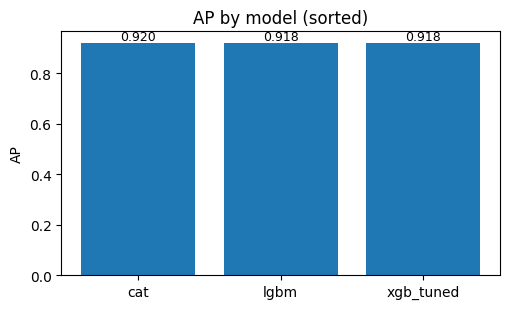

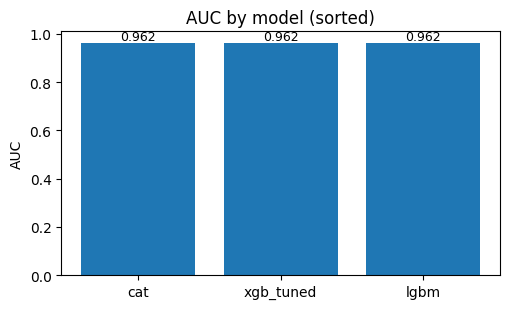

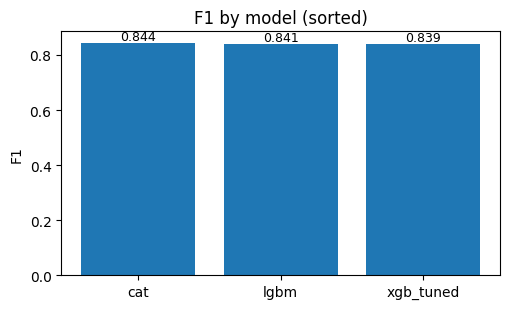

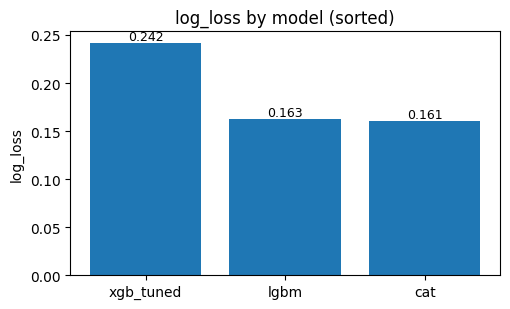

In [9]:
import os, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import log_loss
import pyarrow.parquet as pq

# ---- paths to saved metrics/models
models_dir = Path("models")
artefacts = {
    "cat":       {"metrics": models_dir / "cat_all_features_metrics.json",       "model": models_dir / "cat_all_features_model.joblib"},
    "lgbm":      {"metrics": models_dir / "lgbm_all_features_metrics.json",      "model": models_dir / "lgbm_all_features_model.joblib"},
    "xgb_tuned": {"metrics": models_dir / "tuned_all_features_bo_metrics.json",  "model": models_dir / "tuned_all_features_bo_model.joblib"},
}

# ---- reload the same data + time split you used
IN_PATH   = "data/processed/flights_with_weather.parquet"
EVAL_SIZE = 0.20
BASE_CATEGORICAL = ["AIRLINE","ORIGIN_AIRPORT","DESTINATION_AIRPORT","ORIGIN_STATE","DEST_STATE"]
BASE_NUMERIC     = ["DEPARTURE_DELAY","AIR_TIME","DISTANCE","ORIGIN_LAT","ORIGIN_LON","DEST_LAT","DEST_LON","temp","rhum","prcp","snow","wspd","pres"]

def coerce(df, numeric_cols):
    import pandas as pd
    for c in numeric_cols + ["is_delayed"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "is_delayed" in df.columns:
        df["is_delayed"] = df["is_delayed"].fillna(0).astype(int)
    for c in numeric_cols:
        if c in df.columns:
            df[c] = df[c].astype("float32")
    if "FL_DATE" in df.columns:
        df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], errors="coerce")
    for c in BASE_CATEGORICAL:
        if c in df.columns:
            df[c] = df[c].astype("category")
    return df

def time_holdout(df, eval_size):
    df = df.sort_values("FL_DATE")
    cut = int((1.0 - eval_size) * len(df))
    return df.iloc[:cut], df.iloc[cut:]

df = coerce(pq.read_table(IN_PATH).to_pandas(), BASE_NUMERIC)
X_all = df[BASE_CATEGORICAL + BASE_NUMERIC + (["FL_DATE"] if "FL_DATE" in df.columns else [])].copy()
y_all = df["is_delayed"].values
tmp = X_all.join(pd.Series(y_all, name="y"))
train_pool, final_valid = time_holdout(tmp, EVAL_SIZE)
X_valid = final_valid.drop(columns=["y","FL_DATE"], errors="ignore")
y_valid = final_valid["y"].values

# helper for XGB Booster (native) predictions at best_iter
def _xgb_predict_proba(booster, X, best_iter: int):
    import xgboost as xgb
    def make_dm(Xdf):
        try:
            return xgb.DMatrix(Xdf, feature_names=list(Xdf.columns), enable_categorical=True)
        except TypeError:
            Xc = Xdf.copy()
            for c in Xc.select_dtypes(include="category").columns:
                Xc[c] = Xc[c].cat.codes.astype("int32")
            return xgb.DMatrix(Xc, feature_names=list(Xc.columns))
    dm = make_dm(X)
    try:
        return booster.predict(dm, iteration_range=(0, best_iter+1))
    except TypeError:
        return booster.predict(dm, ntree_limit=best_iter+1)

# ---- build table
rows = []
for name, paths in artefacts.items():
    with open(paths["metrics"], "r") as f:
        m = json.load(f)

    # base metrics from JSON
    row = {
        "model": name,
        "best_iter": m.get("best_iteration"),
        "AUC": m.get("roc_auc"),
        "AP": m.get("pr_auc"),
        "F1": m.get("f1_at_threshold"),
        "Precision": m.get("precision_at_threshold"),
        "Recall": m.get("recall_at_threshold"),
        "threshold": m.get("threshold"),
        "learning_rate": (m.get("hyperparams") or {}).get("learning_rate"),
        "max_depth": (m.get("hyperparams") or {}).get("max_depth"),
    }

    # compute log_loss on the same holdout
    model_obj = joblib.load(paths["model"])
    proba = None
    # try XGB Booster-native
    if hasattr(model_obj, "save_config") and "booster" in str(type(model_obj)).lower():
        best_iter = int(row["best_iter"]) if row["best_iter"] is not None else None
        if best_iter is None:
            # fall back: just predict fully grown
            best_iter = 999999
        proba = _xgb_predict_proba(model_obj, X_valid, best_iter)
    else:
        # try standard predict_proba
        if hasattr(model_obj, "predict_proba"):
            proba = model_obj.predict_proba(X_valid)[:, 1]
        else:
            # some boosters use predict for proba
            proba = model_obj.predict(X_valid)
            if proba.ndim > 1:
                proba = proba[:, 1]

    row["log_loss"] = float(log_loss(y_valid, proba, labels=[0,1]))
    rows.append(row)

df = pd.DataFrame(rows).sort_values(["AP","AUC","F1"], ascending=[False, False, False]).reset_index(drop=True)
display(df.style.format({"AUC":"{:.3f}","AP":"{:.3f}","F1":"{:.3f}","Precision":"{:.3f}","Recall":"{:.3f}","log_loss":"{:.5f}"}))
out_csv = models_dir / "model_comparison.csv"
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# ---- nicer bars: sorted by AP and with value labels
def bar_with_labels(metric):
    order = df.sort_values(metric, ascending=False)
    plt.figure(figsize=(5.2,3.2))
    bars = plt.bar(order["model"], order[metric])
    for b, v in zip(bars, order[metric]):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.3f}", ha="center", va="bottom", fontsize=9)
    plt.title(f"{metric} by model (sorted)")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

for m in ["AP","AUC","F1","log_loss"]:
    bar_with_labels(m)


### Conclusion: If you must pick one under current settings, choose CatBoost for the slight AP/F1 edge; otherwise, XGB is a solid co-winner with faster iteration/strong tooling, and LGBM matches AUC with competitive AP/F1.